# Second stage summary

In the first stage, we established that selecting a simple portfolio built with classical methods is more reliable than attempting to select or compose a portfolio using machine learning, in particular neural networks.

During the second stage, we wanted to establish whether adding more relevant features to the training data and reducing the problem to a simple forecast (of future covariance or future returns) is a viable strategy. If this does not improve the base model, it will confirm our hypothesis that portfolio allocation should be performed based on fundamentals of portfolio theory and economics, rather than based on advanced analytics and forecasting.

This summary consists of following parts:
1. Base model performance testing (classical portfolio theory)
2. Training advanced forecasting model
  - dataset assembly
  - model architecture definition
  - training & validation of created model
3. Comparison of test results between base and advanced model

## Base model performance

In [1]:
import pandas as pd
import numpy as np

from numba import jit

from typing import Tuple

from utils.data_loader import *

from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [2]:
class OneYearTest(object):
    """
    Scikit-learn style iterator returning training- and test-set indices,
    where test set is one-year-long and training set consists of n_train_years
    preceding the test set year.
    """
    def __init__(self, df: pd.DataFrame, n_train_years: int=10):
        self.index_years = df.index.year
        self.unique_years = np.unique(self.index_years)
        self.n_train_years = n_train_years
        
    @property
    def train_years(self):
        return set(self.unique_years[self.idx-self.n_train_years:self.idx])
    
    @property
    def test_year(self):
        return self.unique_years[self.idx]

    def __iter__(self):
        self.idx = self.n_train_years
        return self
    
    def __next__(self):
        if self.idx < len(self.unique_years):
            train_ids = self.index_years.isin(self.train_years)
            test_ids = self.index_years == self.test_year
            self.idx += 1
            return train_ids, test_ids
        else:
            raise StopIteration

In [3]:
@jit(nopython=True)
def portfolio_performance(allocation: np.array, fund_values: np.array) -> Tuple[float, float]:
    """
    Calculates total returns and daily returns volatility during entire period of provided fund values.
    """
    allocation_value = np.sum(allocation * fund_values, axis=1) / np.sum(allocation)
    period_returns = (allocation_value[-1] - allocation_value[0]) / allocation_value[0]
    daily_returns = (allocation_value[1:] - allocation_value[:-1]) / allocation_value[:-1]
    period_volatility = np.std(daily_returns)
    return period_returns, period_volatility

In [4]:
@jit(nopython=True)
def portfolio_srri(allocation: np.array, fund_values: np.array) -> int:
    """
    Calculates SRRI based on porfolio volatility 
    during last 5 years of provided fund_values,
    as described in https://bit.ly/2RDVib9
    """
    m = 260  # days in a year, as in the SRRI paper
    T = 5*260  # days in 5 years, as in the SRRI paper
    allocation_value = np.sum(allocation * fund_values[-T:], axis=1) / np.sum(allocation)
    daily_returns = (allocation_value[1:] - allocation_value[:-1]) / allocation_value[:-1]
    scaled_volatility = np.sqrt(m * np.sum((daily_returns - np.mean(daily_returns))**2) / (T-1))
    if scaled_volatility >= 0.25:
        return 7
    elif scaled_volatility >= 0.15:
        return 6
    elif scaled_volatility >= 0.1:
        return 5
    elif scaled_volatility >= 0.05:
        return 4
    elif scaled_volatility >= 0.02:
        return 3
    elif scaled_volatility >= 0.005:
        return 2
    else:
        return 1

In [5]:
def base_model(funds_df: pd.DataFrame) -> np.array:
    mu = mean_historical_return(funds_df)
    S = CovarianceShrinkage(funds_df).ledoit_wolf()
    ef = EfficientFrontier(mu, S)
    ef.efficient_return(0.04)
    return ef.weights

### Loading data

In [6]:
funds_df = load_funds()
funds_df.head()

,AP,ARR,ARW,G,OP,ORR,ORW
Daty,,,,,,,
2000-01-03,415.90,549.11,354.45,401.26,275.08,520.13,230.72
2000-01-04,404.41,533.89,357.14,401.42,275.08,520.02,229.63
2000-01-05,400.04,527.38,351.19,401.59,275.08,519.22,229.22
2000-01-06,410.15,522.02,347.96,401.75,275.07,519.62,228.82
2000-01-07,429.16,533.16,351.87,401.93,275.07,520.80,230.09


### Evaluating model performance

In [7]:
result_dfs = []
for train_ids, test_ids in OneYearTest(funds_df):
    train_, test_ = funds_df[train_ids], funds_df[test_ids]
    allocation = base_model(train_)
    allocation_data = {fund: allocation[idx] for idx, fund in enumerate(funds_df.columns)}
    srri = portfolio_srri(allocation, train_.values)
    returns, volatility = portfolio_performance(allocation, test_.values)
    performance_data = {'srri': srri, 'returns': returns, 'volatility': volatility}
    result_dfs.append(
        pd.DataFrame({**allocation_data, **performance_data}, index=[test_.index.year[0]])
    )
base_results_df = pd.concat(result_dfs, axis='index')
base_results_df

,AP,ARR,ARW,G,OP,ORR,ORW,srri,returns,volatility
2010,0.000000e+00,0.097180,0.000000e+00,0.029988,4.685533e-18,0.872832,0.000000e+00,3,0.039771,0.001369
2011,0.000000e+00,0.072626,2.120622e-18,0.137887,0.000000e+00,0.789487,0.000000e+00,3,0.049100,0.001130
2012,0.000000e+00,0.029938,2.775558e-17,0.163534,1.110223e-16,0.806528,4.996004e-16,3,0.038907,0.001017
2013,0.000000e+00,0.000000,2.498002e-16,0.396435,9.826165e-02,0.505303,0.000000e+00,2,0.007480,0.000924
2014,1.387779e-16,0.011953,0.000000e+00,0.369706,1.710975e-01,0.438951,8.292950e-03,2,0.057371,0.000711
2015,0.000000e+00,0.047583,0.000000e+00,0.406317,1.323265e-01,0.412050,1.723540e-03,2,0.006546,0.001059
2016,0.000000e+00,0.007411,0.000000e+00,0.337597,2.057501e-01,0.339308,1.099335e-01,2,0.020865,0.001130
2017,2.602085e-18,0.000000,0.000000e+00,0.312992,2.390520e-01,0.309681,1.382744e-01,2,0.029053,0.000803
2018,0.000000e+00,0.004771,4.987330e-18,0.307000,2.338743e-01,0.305518,1.488360e-01,2,0.007488,0.000779


## Advanced model performance

We will attempt to train a deep neural network, that will attempt to predict future returns as well as future fund value covariance.

In [8]:
from dataclasses import dataclass, asdict
import multiprocessing as mp

from tqdm import tqdm

import ta

### External data

### Feature generation

For our fund values, we calculate similar features to the ones mentioned by: *Bao, W., Yue, J., Rao, Y. (2017). A deep learning framework for financial time series
using stacked autoencoders and long-short term memory.*

In [9]:
fund_column_features = {
    'MACD': lambda col: ta.trend.macd(col, n_fast=80, n_slow=160),
    'BBL': lambda col: ta.volatility.bollinger_lband(col, n=120),
    'BBH': lambda col: ta.volatility.bollinger_hband(col, n=120),
    'EMA': lambda col: ta.trend.ema_indicator(col, n=240),
}

ohlc_column_features = {
    # TODO
}

In [10]:
features_df = pd.DataFrame(index=funds_df.index)
for key in tqdm(fund_column_features):
    for col in funds_df.columns:
        features_df[f'{col}_{key}'] = fund_column_features[key](funds_df[col])

100%|██████████| 4/4 [00:00<00:00, 61.94it/s]


### Target generation

In [11]:
@dataclass
class Target(object):
    fund_returns: np.array
    fund_covariance: np.array
    ideal_allocation: np.array
    ideal_returns: float

In [12]:
def calculate_target(funds_df: pd.DataFrame) -> Target:
    mu = mean_historical_return(funds_df)
    S = CovarianceShrinkage(funds_df).ledoit_wolf()
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(0.1)
    ideal_allocation = ef.weights
    ideal_returns = ef.portfolio_performance()[0]
    return Target(mu, S, ideal_allocation, ideal_returns)

We calculate all target data in parallel to save time:

In [13]:
%%time
YEAR_DAYS = 260

dfs = [
    funds_df[idx+1 : idx+1+YEAR_DAYS]
    for idx in range(funds_df.iloc[:-YEAR_DAYS].shape[0])
]
with mp.Pool(processes=12) as pool:
    targets = pool.map(calculate_target, dfs)

print(len(targets))

4541
CPU times: user 5.43 s, sys: 348 ms, total: 5.78 s
Wall time: 26.1 s


Then, we extract information necessary for our experiment and back it up:

In [14]:
returns_target = np.zeros_like(funds_df[:-YEAR_DAYS])
covariance_target = np.zeros(
    (len(funds_df[:-YEAR_DAYS]), funds_df.shape[1]**2)
)
sample_weights = np.zeros(len(funds_df[:-YEAR_DAYS]))

for idx, target in enumerate(targets):
    returns_target[idx] = target.fund_returns.values.ravel()
    covariance_target[idx] = target.fund_covariance.values.ravel()
    sample_weights[idx] = target.ideal_returns  # years with higher returns are more important

np.save('data/forecasting/returns_target.npy', returns_target)
np.save('data/forecasting/covariance_target.npy', covariance_target)
np.save('data/forecasting/sample_weights.npy', sample_weights)

We can also add past targets to our features:

In [15]:
returns_features = np.zeros_like(funds_df)
returns_features[:YEAR_DAYS] = np.nan
returns_features[YEAR_DAYS:] = returns_target

covariance_features = np.zeros(
    (len(funds_df), funds_df.shape[1]**2)
)
covariance_features[:YEAR_DAYS] = np.nan
covariance_features[YEAR_DAYS:] = covariance_target

weights_features = np.zeros(len(funds_df))
weights_features[:YEAR_DAYS] = np.nan
weights_features[YEAR_DAYS:] = sample_weights

### Model definition

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(42)

assert(torch.cuda.is_available())
cuda_device = 0
torch.cuda.empty_cache()

In [35]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2, cuda_device=cuda_device):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.cuda_device = cuda_device

        self.lstm = nn.LSTM(
            self.input_dim, 
            self.hidden_dim, 
            self.num_layers,
            batch_first=True
        )
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        self.hidden = (
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(cuda_device).type(torch.float32),
            torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(cuda_device).type(torch.float32)
        )
        return self.hidden

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input)
        # shape of lstm_out: [batch_size, seq_len, hidden_dim]
        y_pred = self.linear(lstm_out[:,-1].view(self.batch_size, -1))
        return y_pred.view(-1)

### Training & evaluation

In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [37]:
all_features = np.hstack([features_df.values, returns_features, covariance_features, weights_features.reshape(-1, 1)])
features_valid = np.all(~np.isnan(all_features), axis=1)
feature_scaler = MinMaxScaler()
all_features[features_valid] = feature_scaler.fit_transform(all_features[features_valid])

all_targets = np.hstack([returns_target, covariance_target])
targets_valid = np.all(~np.isnan(all_targets), axis=1)
target_scaler = StandardScaler()
all_targets[targets_valid] = target_scaler.fit_transform(all_targets[targets_valid])

# unlike features, targets are only generated when they are valid
assert(sum(targets_valid) == len(targets_valid))
assert(len(targets_valid) < len(features_valid))
# so last year of features cannot have any target associated with it (no data to compute the target)
all_features = all_features[:len(targets_valid)]
features_valid = features_valid[:len(targets_valid)]

# this is created for one-year-validation to have a correct index for data splitting
meta_df = pd.DataFrame({'valid': features_valid}, index=funds_df.iloc[:len(features_valid)].index)

In [38]:
all_features.shape, all_targets.shape

((4541, 85), (4541, 56))

In [39]:
def as_sequences(
        X: np.array, 
        y: np.array, 
        seq_len: int, 
        batch_size: int, 
        cuda_device: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Allocates GPU memory for features and labels, 
    making sure they are in correct shape for LSTM:
    X: (n_batches, batch_size, sequence_length, n_features)
    y: (n_batches, batch_size, n_targets)
    """
    assert(len(X) == len(y))
    
    n_samples, n_features = X.shape
    n_targets = y.shape[1]
    n_batches = (n_samples-seq_len) // batch_size
    X_seqs = np.zeros((n_batches, batch_size, seq_len, n_features))
    y_labels = np.zeros((n_batches, batch_size, n_targets))
    for batch_idx in range(n_batches):
        X_seqs[batch_idx] = np.reshape(
            np.array([X[idx:idx+seq_len] for idx in range(batch_size*batch_idx, batch_size*(batch_idx+1))]),
            (batch_size, seq_len, n_features)
        )
        y_labels[batch_idx] = np.reshape(
            np.array([y[idx+seq_len-1] for idx in range(batch_size*batch_idx, batch_size*(batch_idx+1))]),
            (batch_size, n_targets)
        )
    return torch.from_numpy(X_seqs).to(cuda_device).type(torch.float32), torch.from_numpy(y_labels).to(cuda_device).type(torch.float32)

#### Training parameters

In [40]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

In [41]:
n_epochs = 6
lr = 0.0005
model_hidden_dim = 60
seq_len = 3*YEAR_DAYS
val_set_len = YEAR_DAYS
batch_size = 1  # WARNING: Other sizes may not work right now

Perform these in each test set setting:

In [42]:
def train(model, X_train_, y_train_, X_valid_, y_valid_, n_epochs: int=n_epochs):
    model.to(cuda_device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = torch.nn.MSELoss()
    train_loss_vals = np.zeros(n_epochs)
    eval_loss_vals = np.zeros(n_epochs)
    for ep_idx in range(n_epochs):
        model.init_hidden()
        for idx, (X_batch, y_batch) in tqdm(
                enumerate(zip(X_train_, y_train_)), 
                total=len(X_train_), 
                desc=f'Training epoch={ep_idx+1}/{n_epochs}'):
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss_val = loss(y_pred, y_batch)
            train_loss_vals[ep_idx] += loss_val.item()
            loss_val.backward()
            optimizer.step()
        train_loss_vals[ep_idx] = train_loss_vals[ep_idx] / len(X_train_)  # average training loss
        for idx, (X_batch, y_batch) in tqdm(
                enumerate(zip(X_valid_, y_valid_)), 
                total=len(X_valid_), 
                desc=f'Validating epoch={ep_idx+1}/{n_epochs}'):
            with torch.no_grad():
                y_pred = model(X_batch)
                loss_val = loss(y_pred, y_batch)
                eval_loss_vals[ep_idx] += loss_val.item()
        eval_loss_vals[ep_idx] = eval_loss_vals[ep_idx] / len(X_valid_)
    plt.plot(train_loss_vals, color='red', label='training loss')
    plt.plot(eval_loss_vals, color='blue', label='validation loss')
    plt.title(f'Model {model.__class__.__name__}, results after {n_epochs} epochs')
    plt.legend()
    plt.show()
    return model, train_loss_vals, eval_loss_vals

In [43]:
def predict_allocate(model, X, transformer, n_funds=7):
    with torch.no_grad():
        # reshape preserves dimensions when batch_size=1
        y_pred = model(X).reshape(len(X), -1).cpu().numpy()
    y_last_pred = transformer.inverse_transform(y_pred[-1])
    mu = y_last_pred[:n_funds]
    S = y_last_pred[n_funds:].reshape((n_funds, n_funds))
    ef = EfficientFrontier(mu, S)
    ef.efficient_risk(0.09)  # 0.01 threshold for safety
    # normalizing output in case scaling and 32bit casts for GPU
    # altered it resulting in allocation of more than 100% of portfolio
    weights = normalize([ef.weights])[0]
    return weights

Validating epoch=6/6: 100%|██████████| 259/259 [00:04<00:00, 57.47it/s]


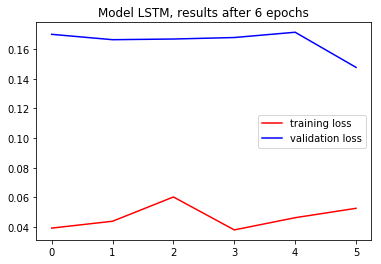

{'srri': 2, 'returns': 0.08105022887805866, 'volatility': 0.0006891689200532578}


Validating epoch=6/6: 100%|██████████| 259/259 [00:04<00:00, 57.94it/s]


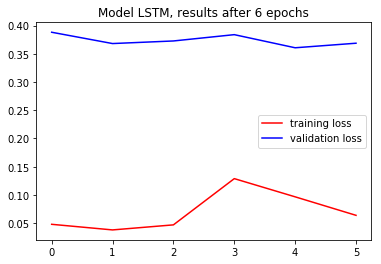

{'srri': 2, 'returns': -0.002525221985484849, 'volatility': 0.0014532800867424437}


Validating epoch=6/6: 100%|██████████| 259/259 [00:04<00:00, 57.91it/s]


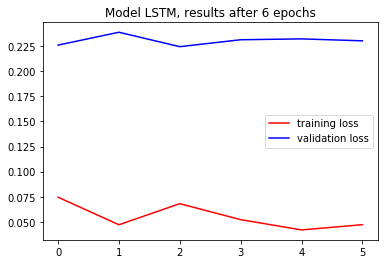

{'srri': 4, 'returns': 0.03850478125210188, 'volatility': 0.0032369346325399253}


Validating epoch=6/6: 100%|██████████| 259/259 [00:04<00:00, 57.81it/s]


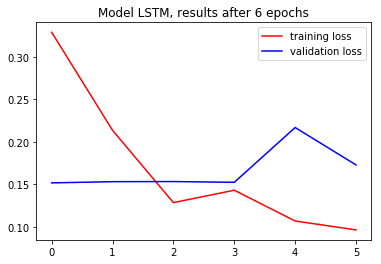

{'srri': 3, 'returns': 0.005458349658999213, 'volatility': 0.0017323005342870109}


Validating epoch=6/6: 100%|██████████| 259/259 [00:04<00:00, 57.61it/s]


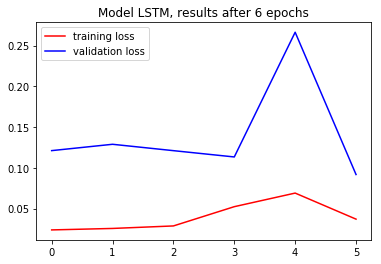

{'srri': 3, 'returns': 0.022166747800544465, 'volatility': 0.002086591894085548}


Validating epoch=6/6: 100%|██████████| 259/259 [00:04<00:00, 57.80it/s]


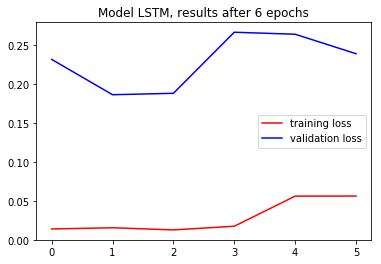

{'srri': 3, 'returns': 0.07553842668960126, 'volatility': 0.0015599564630829712}


,AP,ARR,ARW,G,OP,ORR,ORW,srri,returns,volatility
2012,1.674511e-09,1.974069e-08,1.656124e-09,6.440886e-01,7.009946e-01,2.905477e-01,0.096636,2,0.081050,0.000689
2013,0.000000e+00,0.000000e+00,0.000000e+00,7.400799e-01,4.395459e-01,2.139303e-01,0.461860,2,-0.002525,0.001453
2014,9.604220e-16,8.879728e-01,0.000000e+00,4.598959e-01,3.715569e-16,1.324894e-15,0.000000,4,0.038505,0.003237
2015,7.703118e-12,1.893083e-02,9.219335e-12,5.548045e-12,6.567170e-01,6.419004e-01,0.395384,3,0.005458,0.001732
2016,0.000000e+00,0.000000e+00,0.000000e+00,8.411200e-12,2.642031e-10,1.000000e+00,0.000000,3,0.022167,0.002087
2017,1.358821e-16,0.000000e+00,5.506612e-15,0.000000e+00,6.288322e-16,3.002657e-01,0.953856,3,0.075538,0.001560


In [44]:
models = []
result_dfs = []
truncated_funds_df = funds_df[:len(meta_df.index)]
for train_ids, test_ids in OneYearTest(meta_df):  # TODO: Support batch_size other than 1 in OneYearTest
    if not meta_df.iloc[train_ids]['valid'].all():
        continue
    X, y = all_features[train_ids], all_targets[train_ids]
    assert(~np.any(np.isnan(X)))
    assert(~np.any(np.isnan(y)))
    
    X, y = as_sequences(X, y, seq_len=seq_len, batch_size=batch_size, cuda_device=cuda_device)
    X_train_ = X[:-val_set_len]
    y_train_ = y[:-val_set_len]
    X_valid_ = X[-val_set_len:-1]
    y_valid_ = y[-val_set_len:-1]
    X_test_batch_ = X[-1]  # for portfolio construction, separate from validation
    
    model = LSTM(
        input_dim=all_features.shape[1], 
        hidden_dim=model_hidden_dim,
        output_dim=all_targets.shape[1],
        batch_size=1
    )
    model, _, _ = train(model, X_train_, y_train_, X_valid_, y_valid_)
    models.append(model)
    
    allocation = predict_allocate(model, X_test_batch_, target_scaler)
    allocation_data = {fund: allocation[idx] for idx, fund in enumerate(funds_df.columns)}
    srri = portfolio_srri(allocation, truncated_funds_df[train_ids].values)
    returns, volatility = portfolio_performance(allocation, truncated_funds_df[test_ids].values)
    performance_data = {'srri': srri, 'returns': returns, 'volatility': volatility}
    print(performance_data)
    result_dfs.append(
        pd.DataFrame({**allocation_data, **performance_data}, index=[truncated_funds_df[test_ids].index.year[0]])
    )
lstm_results_df = pd.concat(result_dfs, axis='index')
lstm_results_df

## Results comparison

In [48]:
combined_results = base_results_df.join(lstm_results_df, rsuffix='_LSTM')

In [50]:
combined_results[['srri', 'returns', 'volatility', 'srri_LSTM', 'returns_LSTM', 'volatility_LSTM']]

,srri,returns,volatility,srri_LSTM,returns_LSTM,volatility_LSTM
2010,3,0.039771,0.001369,NaN,NaN,NaN
2011,3,0.049100,0.001130,NaN,NaN,NaN
2012,3,0.038907,0.001017,2.0,0.081050,0.000689
2013,2,0.007480,0.000924,2.0,-0.002525,0.001453
2014,2,0.057371,0.000711,4.0,0.038505,0.003237
2015,2,0.006546,0.001059,3.0,0.005458,0.001732
2016,2,0.020865,0.001130,3.0,0.022167,0.002087
2017,2,0.029053,0.000803,3.0,0.075538,0.001560
2018,2,0.007488,0.000779,NaN,NaN,NaN


We can see that LSTM-based portfolio has some advantages, but is also a little riskier.